In [1]:
#load datasets
import geopandas as gpd
import pandas as pd

dfde = gpd.read_parquet('../data/processed_datasets/simplified_refined_DFDE_1984_2021_EPSG2154_FR.parquet') #ok 
hm = gpd.read_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet') #ok 
nfi = gpd.read_parquet('../data/processed_datasets/simplified_NFI_2003-2021_EPSG2154_FR.parquet') #ok 
senfseidl = gpd.read_parquet("../data/processed_datasets/simplified_SenfSeidl_joined_EPSG2154_FR.parquet") #ok 
bdiff = gpd.read_parquet('../data/processed_datasets/simplified_bdiff_2012_2022_FR_EPSG2154.parquet') #ok 
cdi = gpd.read_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet') #ok
forms = gpd.read_parquet('../data/processed_datasets/simplified_FORMS_clearcut_2017_2020_EPSG2154.parquet') #ok
firepolygon = gpd.read_parquet('../data/processed_datasets/simplified_firepolygons_2017_2020_FR_EPSG2154.parquet') #ok

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

#preprocessing bdiff:
firepolygon['class'] = 'Fire'
#add end date with offset of 7 days 
firepolygon['end_date'] = pd.to_datetime(firepolygon['start_date']) + pd.to_timedelta(7, unit='d')
bdiff['class'] = 'Fire'
bdiff = bdiff[ bdiff.forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


bdiff[['start_date', 'end_date']] = bdiff.apply(to_datetime_safe, axis=1, result_type='expand')

#autoreload 
from attribution2 import Attribution
from constants import DCLASS_SCORE

temporal_buffer = 2 

#subset of datasets
ddataset = {'dfde': dfde, 'hm': hm, 'nfi': nfi, 'senfseidl': senfseidl, 'bdiff': bdiff, 'cdi':cdi, 'forms':forms, 'firepolygons':firepolygon}
dtypes = {'dfde': 'polygon', 'hm': 'point', 'nfi': 'point', 'senfseidl': 'point', 'bdiff': 'polygon', 'firepolygons': 'polygon', 'cdi':'polygon', 'forms':'point'}

ddataset_profile = {
    'dfde': {
        'spatial': ('offset_gaussian', {'offset': 150, 'decrease': 5000}), #offset srt( min(area) / pi), k sqrt(median(area) / pi)
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'hm': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 100}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'nfi': {
        'spatial': ('offset_gaussian', {'offset': 600, 'decrease': 25}),
        'temporal': ('step', {'start': 0, 'end': 5 * 365})
    },
    'bdiff': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 30})
    },
    'firepolygons': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 50}),
        'temporal': ('offset_gaussian', {'offset': 7, 'decrease': 31})
    },
    'senfseidl': {
        'spatial': ('offset_gaussian', {'offset': 30, 'decrease': 5 * 30}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 1.5 * 365})
    },
    'forms': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 5*10}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'cdi': {
        'spatial': ('offset_gaussian', {'offset': 5000, 'decrease': 500}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 365})
    },
    'reference': {
        'spatial': ('offset_gaussian', {'offset': 0, 'decrease': 3 * 50}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
}

#visible disturbances
ddisturbance_profile = {
    'fire': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'storm': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1.5 * 365})
    },
    'biotic-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 1000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 365})
    },
    'drought-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 2*365})
    },
    'biotic-mortality': {
        'spatial': ('gaussian', {'mean': 0, 'std': 250}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'anthropogenic': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1 * 365})
    }
}

doa = {'dfde': 1.0, 'hm': 1.0, 'nfi': 1.0, 'senfseidl': .75, 'bdiff': 1.0, 'cdi':.75, 'forms':0.75, 'firepolygons':1.0}
dsbuffer = {'dfde': None, 'hm': 5000, 'nfi': 7000, 'senfseidl': 100, 'bdiff': None, 'cdi':100, 'forms':100, 'firepolygons':100}

attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile, 
                          start_year=2017)

dataset dfde is of spatial entity type
-> 95% of the areas are below : 4391.95 km2, median : 71.66 km2
dataset bdiff is of spatial entity type
-> 95% of the areas are below : 127.49 km2, median : 27.37 km2
dataset cdi is of spatial entity type
-> 95% of the areas are below : 124.78 km2, median : 24.99 km2


In [6]:
a = attribution.ddataset['senfseidl']
dict_distribution = {}
#compute distribution of area according to the distrubance class in column 'class'
for c in a['class'].unique():
    dict_distribution[c] = a[a['class'] == c].geometry.area.to_list()


In [13]:
import numpy as np
np.mean(dict_distribution[c])

13585.24571094809

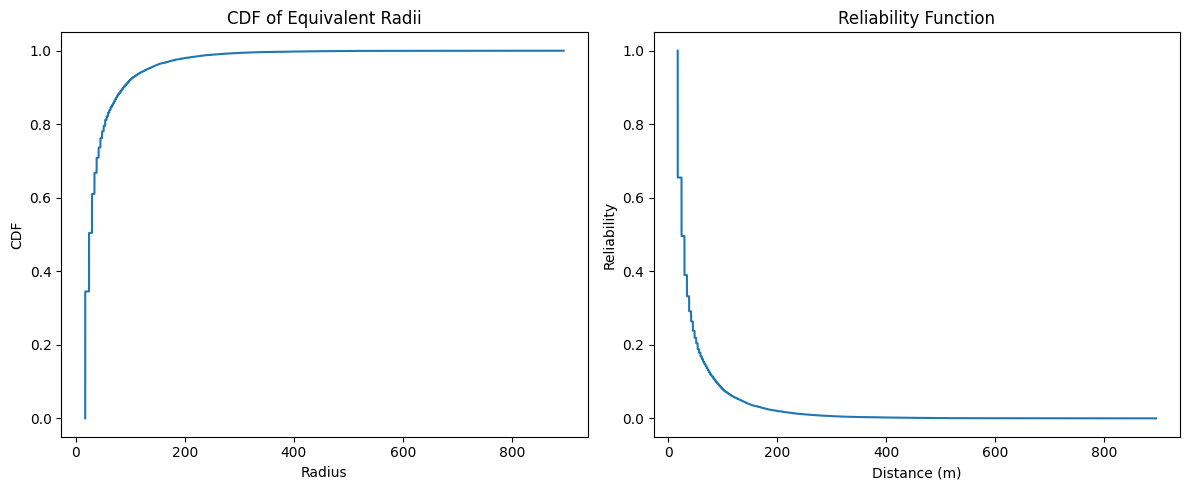

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Convert areas to equivalent radii of disks
radii = np.sqrt(np.array(dict_distribution[c]) / np.pi)

# Sort radii and calculate the CDF
sorted_radii = np.sort(radii)
cdf = np.arange(1, len(sorted_radii) + 1) / len(sorted_radii)

# Derive reliability function from CDF
reliability_function = 1 - cdf

# Plot the CDF and reliability function
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sorted_radii, cdf)
plt.title('CDF of Equivalent Radii')
plt.xlabel('Radius')
plt.ylabel('CDF')

plt.subplot(1, 2, 2)
plt.plot(sorted_radii, reliability_function)
plt.title('Reliability Function')
plt.xlabel('Distance (m)')
plt.ylabel('Reliability')

plt.tight_layout()
plt.show()



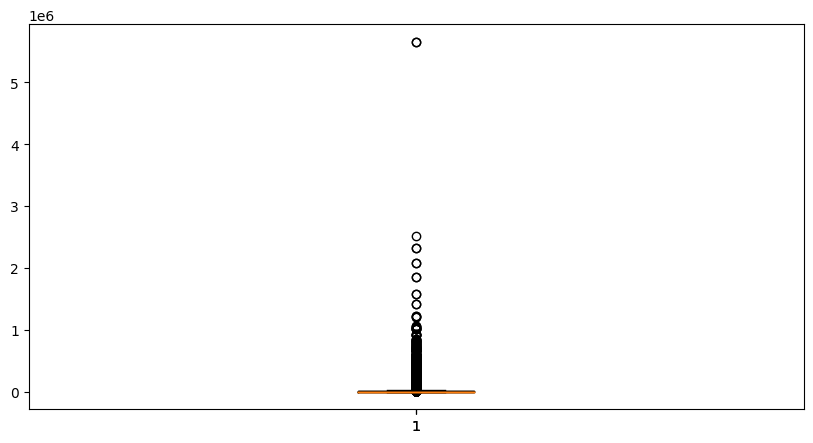

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
for c in a['class'].unique():
    _ = ax.boxplot(dict_distribution[c])